In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import numpy as np
import math

from networkx.algorithms import bipartite
from fa2 import ForceAtlas2
from urllib import error, request
from numba import jit
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from io import BytesIO

from statistics import mean,stdev
import heapq

In [2]:
simsons_api_base_url = "https://simpsons.wikia.com/api/v1"

In [34]:
def api_call(params, limit=100, section="Articles", action="List", clean=False):
    url = f"{simsons_api_base_url}/{section}/{action}?{limit}&{params if params else ''}" if not clean else f"{simsons_api_base_url}/{section}/{params}"
    req = request.Request(url)
    try:
        res = request.urlopen(req).read()
        return json.loads(res.decode("utf-8"))
    except error.HTTPError as err:
        print(err)

In [35]:
def get_season_dictionary():
    seasons = {}
    for i in range(1,31):
        episodes = []
        json_response = api_call(f'category=Season_{i}_episodes')
        for episode in json_response['items']:
            episodes.append(episode['title'])
        seasons[i] = episodes
    return seasons

Reading in the previously created networks

In [3]:
# import os 
# os.chdir("/media/removable/sdcard/SimpsonsGit/social-graphs-team/final_assigment/data_prep")

# TODO: Explain how we build the networks

In [4]:
# Importing previously downloaded 'Simpsons Facbook' network based on character profile pages
SimpsonsFacebook = nx.read_gpickle('linknetwork')
# The same directed version of the same network
DiSimpsonsFacebook = nx.read_gpickle('directed_linknetwork')

# Reading the bipartite network 0: characters, 1: episodes in which
    #each character is connected to the episodes they appear in
BiApperance = nx.read_gpickle('appearance network')

In [5]:
DiSimpsonsFacebook.degree('Homer Simpson')

457

In [6]:
print('Number of nodes in the undirected Simpsons Facebook network: ', SimpsonsFacebook.number_of_nodes())
print('Number of nodes in the directed Simpsons Facebook network: ', DiSimpsonsFacebook.number_of_nodes())
print('Number of nodes in the bipartite Appearance network: ', BiApperance.number_of_nodes())

Number of nodes in the undirected Simpsons Facebook network:  1143
Number of nodes in the directed Simpsons Facebook network:  1145
Number of nodes in the bipartite Appearance network:  1649


# why are there more nodes in the directed than undirected


# Link Network

# TODO: Elaborate on this thing, why we clean the network

In [7]:
# The list of nodes in the Simpson core family
simpsons_family = ['Homer Simpson',
              'Bart Simpson',
              'Marge Simpson',
              'Lisa Simpson',
              'Maggie Simpson']
# Removing these nodes because they're not characters and have a lot of links
DiSimpsonsFacebook.remove_node('Springfield Angry Mob')
DiSimpsonsFacebook.remove_node('Simpson family')
SimpsonsFacebook.remove_node('Springfield Angry Mob')
SimpsonsFacebook.remove_node('Simpson family')

In [8]:
# This is needed for visualisation
degrees = [d for n, d  in SimpsonsFacebook.degree]

colors = []
for n in list(SimpsonsFacebook.nodes()):
    if n in simpsons_family:
        colors.append("#92d4f6")
    else:
        colors.append("#fdd910")

100%|██████████| 500/500 [00:04<00:00, 108.52it/s]


BarnesHut Approximation  took  1.53  seconds
Repulsion forces  took  2.77  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


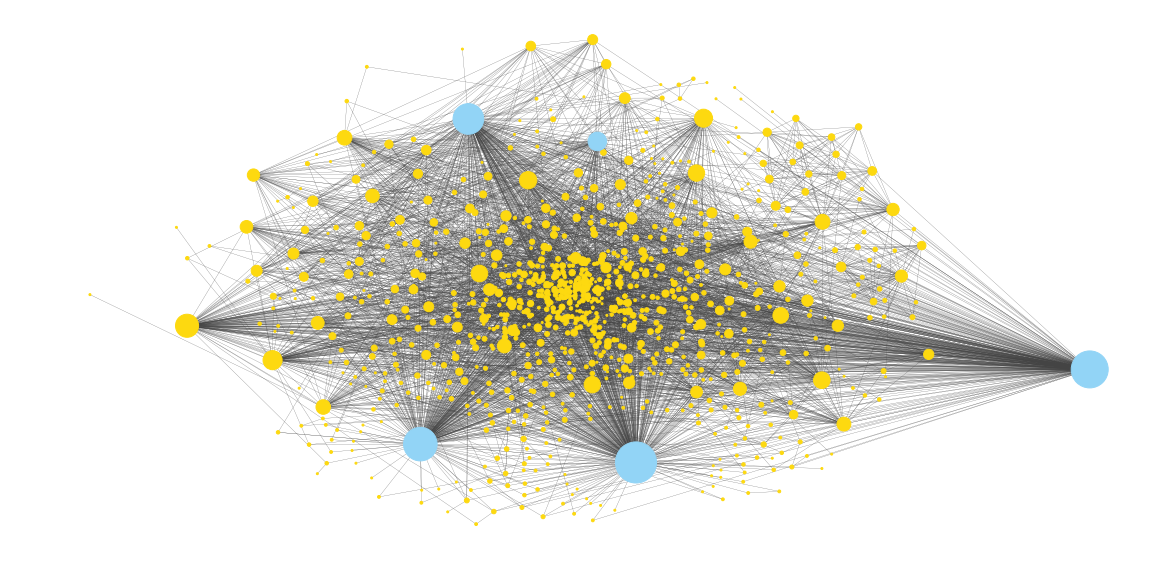

In [9]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.0001,
                          strongGravityMode=False,
                          gravity=2,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(SimpsonsFacebook, pos=None, iterations=500)

fig = plt.figure(figsize=(20,10))
nx.draw_networkx(
    SimpsonsFacebook, 
    positions, 
    cmap=plt.get_cmap('jet'), 
    node_size=[d*4 for d in degrees],
    width=0.2,
    linewidths=1,
    node_color= colors,
    edge_color = '#424242',
    with_labels=False,
    arrows=False
#     with_labels=True,
#     font_size = 5
)
plt.axis('off')
plt.show()

The above networks shows the social network of The Simpsons universe's "recurring characters", connecting characters (nodes) by the hyperlinks to other characters in their Wiki profile pages. This network displays the character connections as would be seen if we were able to capture a snapshot of a Facebook network in the Simpsons universe. From here on, we will refer to this as the "Facebook network". Node size is determined by its degree. As you can see, the 4 largest nodes (and a 5th large node) are blue and denote members of the Simpsons family. The 5th node is Maggie Simpson, who appears in significantly fewer episodes than the rest of the title family. 

As is expected, there are a small number of large nodes. However, there is a considerable number of medium-sized nodes. This is likely due to the tendency of episodes to include a large number of characters. The Wikipedia entries count all appearances in episodes (even cameos in the background), and the producers tend to include characters irrelevant to an episode's plot in a "Where's Waldo?" fashion. Thus, we would expect "recurring characters" to recur regardless of their connection in an episode's plot. 

## Network Statistics

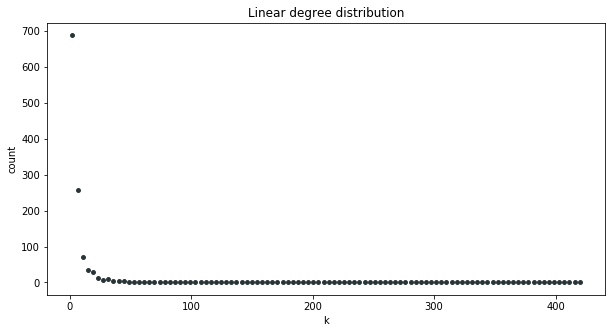

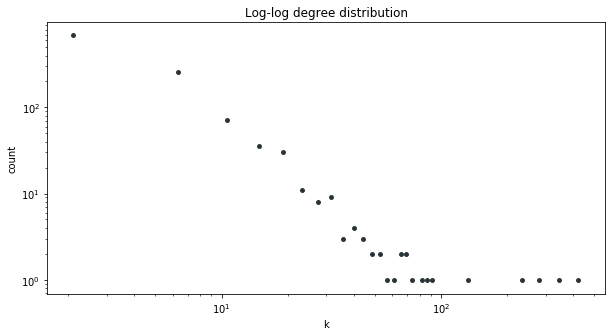

In [10]:
degrees = [d for n, d in SimpsonsFacebook.degree]
hist, bin_edges = np.histogram(degrees,100)

fig = plt.figure(figsize=(10,5))
center = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.scatter(center,hist,15, c="#283336")
plt.title("Linear degree distribution")
plt.xlabel("k")
plt.ylabel("count")
plt.show()

fig = plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('k')
plt.title("Log-log degree distribution")
plt.xlabel("k")
plt.ylabel("count")
for i, value in enumerate(center):
    ax.scatter(value,hist[i],15, c = '#283336')

We see the linear degree distribution follows the power law, as does the log-log distribution. Interestingly, the distributions appear to be implying a disassortative network. However, in the network, we see that the high-degree nodes are very much connected. While disassortative networks typically see hubs avoid connecting with each other, the Facebook network sees the smallest nodes connecting to the title characters. These would include characters like a one-time substitute teacher for Bart Simpson or a seldom-seen classmate of Lisa Simpson. The small size of these nodes and their tendency to connect mainly (or even solely) to main characters appears to balance out the connection of the few hubs. 

In [11]:
# Centralities
b = nx.betweenness_centrality(SimpsonsFacebook)
betweennessList = sorted(b.items(), key=lambda kv: kv[1], reverse=True)
e = nx.eigenvector_centrality(SimpsonsFacebook)
eigenList = sorted(e.items(), key=lambda kv: kv[1], reverse=True)

100%|██████████| 500/500 [00:04<00:00, 116.64it/s]


BarnesHut Approximation  took  1.43  seconds
Repulsion forces  took  2.57  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


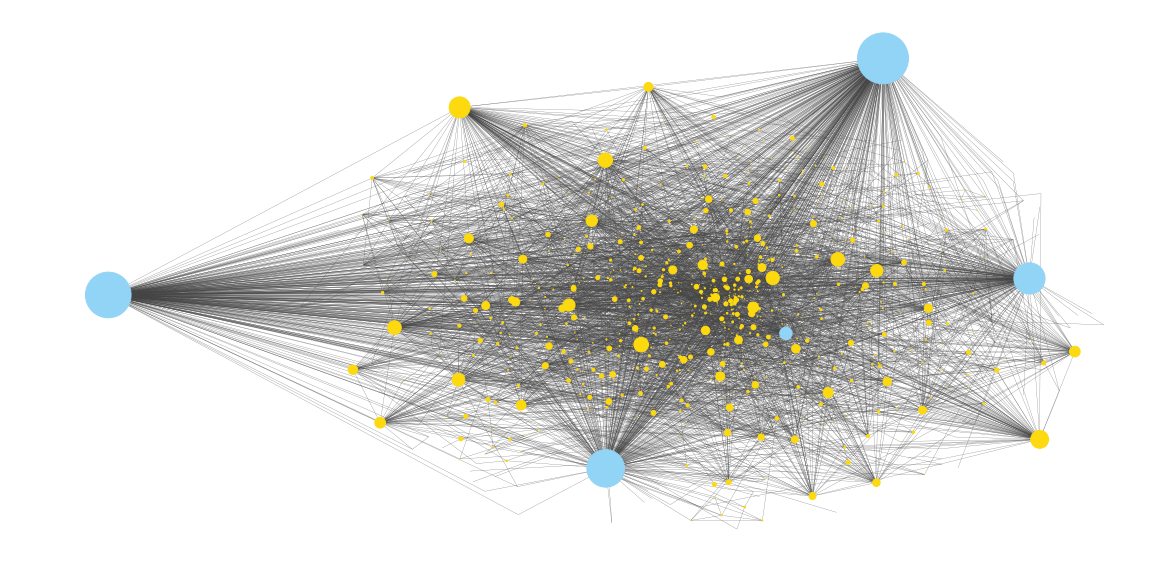

In [18]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.0001,
                          strongGravityMode=False,
                          gravity=2,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(SimpsonsFacebook, pos=None, iterations=500)

fig = plt.figure(figsize=(20,10))
nx.draw_networkx(
    SimpsonsFacebook, 
    positions, 
    cmap=plt.get_cmap('jet'), 
    node_size=[b*10000 for b in list(b.values())],
    width=0.2,
    linewidths=1,
    node_color= colors,
    edge_color = '#424242',
    with_labels=False,
    arrows=False
#     with_labels=True,
#     font_size = 5
)
plt.axis('off')
plt.show()

In [21]:
print('As we would expect here are the top characters in terms of betweeness centrality:')
betweennessList[:10]

As we would expect here are the top characters in terms of betweeness centrality:


[('Homer Simpson', 0.23781725057904882),
 ('Bart Simpson', 0.18342815625396858),
 ('Lisa Simpson', 0.12646611496326585),
 ('Springfield Angry Mob', 0.11566116490587619),
 ('Marge Simpson', 0.08462923845384765),
 ('Charles Montgomery Burns', 0.04006199705966945),
 ('Krusty the Clown', 0.028798616369008913),
 ('Simpson family', 0.027584962611664137),
 ('Audrey McConnell', 0.024723522745527),
 ('Ned Flanders', 0.01853497030616028)]

As the betweenness centrality shows the typicality of a node to be included in a shortest path between any 2 nodes, these characters' rank appears to make sense. The top 4 are the non-infant title characters, while the 5th and 6th are significant figures in the Simpsons community. Mr. Burns and Krusty appear in a large number of episodes and have interacted with a large number of nodes in the network, as they are important to the community as the rich man who owns a large employer of Springfield and television show host, respectively. 

To a lesser extent, the next 3 likely have a high betweenness centrality due to their proximity to title characters. Milhouse and Seymour are significant parts of Bart and Lisa's school community, and Ned is a next-door neighbor to the Simpsons. 

Audrey McConnell is an interesting case. Digging into her neighbors (and their neighbors, in turn) we see: 

In [22]:
for student in list(SimpsonsFacebook.neighbors("Audrey McConnell")):
    print(student)
    
print()
for student in list(SimpsonsFacebook.neighbors("Audrey McConnell's Student 1")):
    print(student)
    
print()
for student in list(SimpsonsFacebook.neighbors("Audrey McConnell's Student 2")):
    print(student)

print()
for student in list(SimpsonsFacebook.neighbors("Audrey McConnell's Student 4")):
    print(student)

Ashley
Ashley (3rd Grader)
Audrey McConnell's Student 1
Audrey McConnell's Student 2
Audrey McConnell's Student 4
Boy with bangs
Boy with freckles
Boy with glasses
Brown-haired girl
Dakota (Orange)
Female Twin
Girl with ponytail
Kevin (Stealing First Base)
Kyle's Sister
Male Twin
Bart Simpson
Lisa Simpson
Elizabeth Hoover
Edna Krabappel
Morgan (3rd Grader)
Mr. Benzie's Students
Mrs. Rhenquist
Rex (Bart of Darkness)
Sara (Student)
Springfield Angry Mob
Tyler (Female 3rd Grader)
Tyler (Male 3rd Grader)

Q-Bert Spuckler
Audrey McConnell

Audrey McConnell
Elizabeth Hoover

Audrey McConnell


3 of these students are "Audrey McConnell's Student". Looking at their sets of neighbors, we see their only main connection is Audrey McConnell. The remote nature of these nodes (and Audrey's proximity to Lisa Simpson in the network) gives Audrey a significant increase in her betweenness centrality value. 

100%|██████████| 500/500 [00:04<00:00, 113.70it/s]


BarnesHut Approximation  took  1.46  seconds
Repulsion forces  took  2.65  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


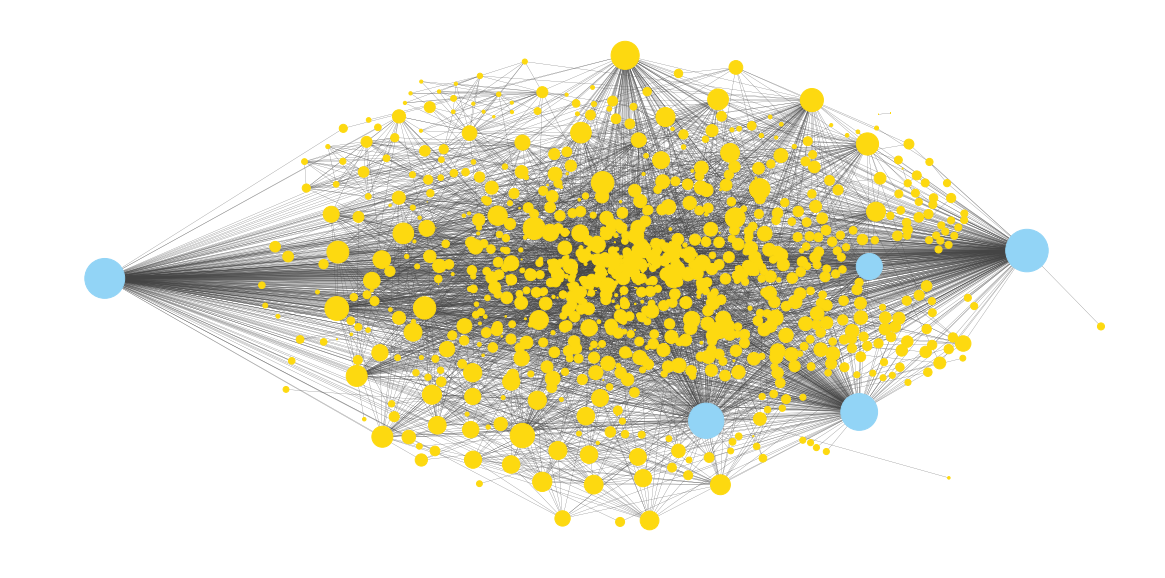

In [20]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.0001,
                          strongGravityMode=False,
                          gravity=2,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(SimpsonsFacebook, pos=None, iterations=500)

fig = plt.figure(figsize=(20,10))
nx.draw_networkx(
    SimpsonsFacebook, 
    positions, 
    cmap=plt.get_cmap('jet'), 
    node_size=[e*5000 for e in list(e.values())],
    width=0.2,
    linewidths=1,
    node_color= colors,
    edge_color = '#424242',
    with_labels=False,
    arrows=False
#     with_labels=True,
#     font_size = 5
)
plt.axis('off')
plt.show()

In [23]:
print('We can see that the characters related more closely to the Simpson core family have higher eigenvector centrality:')
eigenList[:10]

We can see that the characters related more closely to the Simpson core family have higher eigenvector centrality:


[('Homer Simpson', 0.3438967871774513),
 ('Bart Simpson', 0.2954855236581184),
 ('Lisa Simpson', 0.2508196280541712),
 ('Marge Simpson', 0.2355550841610767),
 ('Springfield Angry Mob', 0.2121374473291072),
 ('Charles Montgomery Burns', 0.15387411204656629),
 ('Maggie Simpson', 0.12592131343142762),
 ('Abraham Simpson II', 0.11506323097568773),
 ('Ned Flanders', 0.10828808792075155),
 ('Krusty the Clown', 0.1050102995400784)]

With the eigenvector centrality, we see many names from the betweenness centrality list. However, there are 2 new additions: Maggie Simpson and Abraham Simpson II. Neither of these 2 characters have a high betweenness centrality because they have very few social connections in the show, making their inclusion in short paths somewhat cumbersome. However, they are heavily connected to the Simpsons family (being a part of it themselves) and Montgomery Burns (the 5th highest-connected node). 

## Removing the Simpsons

The main aspect of the Facebook network that differentiates it from a real social network are the ubiquitous Simpsons. In the real world, no average family would have connections to such a high percentage of nodes. To explore a more realistic version of the network, we are able to remove the Simpsons and see the impact this has on our statistics. 

In [12]:
# Removing the Simpsons from the network
SimpsonsFacebook_noSimpsons = SimpsonsFacebook.copy()
SimpsonsFacebook_noSimpsons.remove_nodes_from(simpsons_family)

In [13]:
degrees = [d for n, d  in SimpsonsFacebook_noSimpsons.degree]

colors = []
for n in list(SimpsonsFacebook_noSimpsons.nodes()):
    if n in simpsons_family:
        colors.append("#92d4f6")
    else:
        colors.append("#fdd910")

100%|██████████| 500/500 [00:04<00:00, 112.19it/s]


BarnesHut Approximation  took  1.42  seconds
Repulsion forces  took  2.74  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


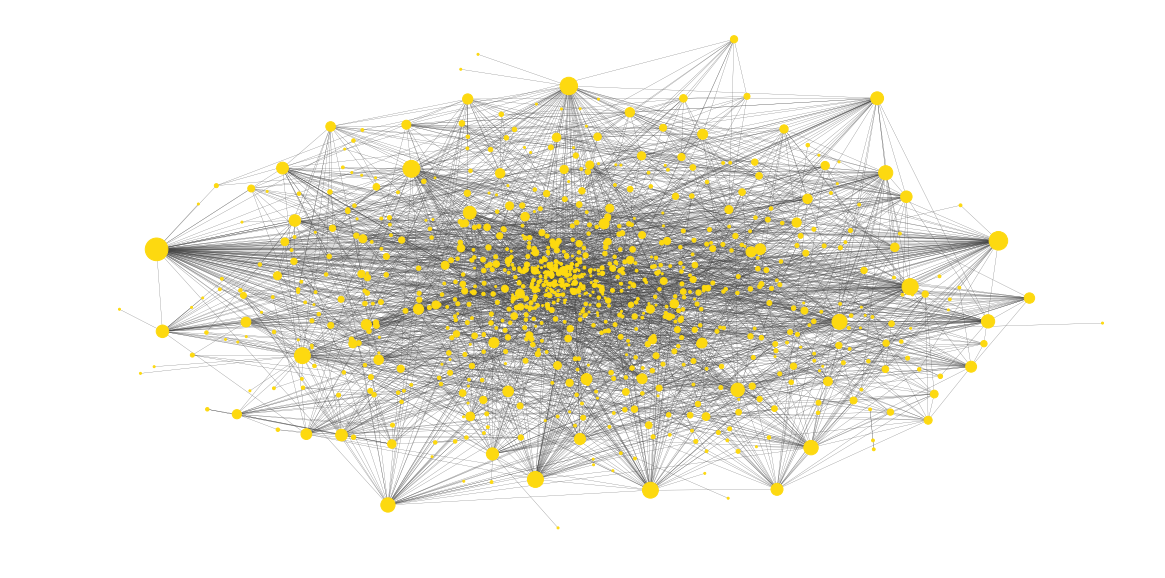

In [14]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.0001,
                          strongGravityMode=False,
                          gravity=2,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(SimpsonsFacebook_noSimpsons, pos=None, iterations=500)

fig = plt.figure(figsize=(20,10))
nx.draw_networkx(
    SimpsonsFacebook_noSimpsons, 
    positions, 
    cmap=plt.get_cmap('jet'), 
    node_size=[d*4 for d in degrees],
    width=0.2,
    linewidths=1,
    node_color= colors,
    edge_color = '#424242',
    with_labels=False,
    arrows=False
#     with_labels=True,
#     font_size = 5
)
plt.axis('off')
plt.show()

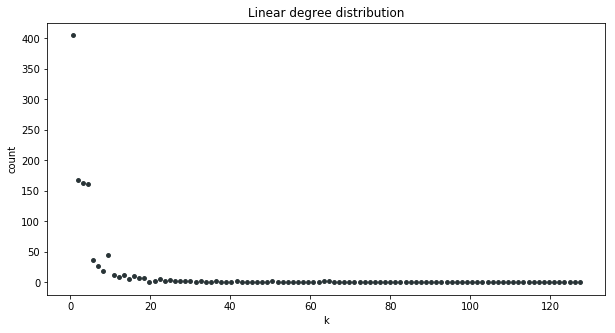

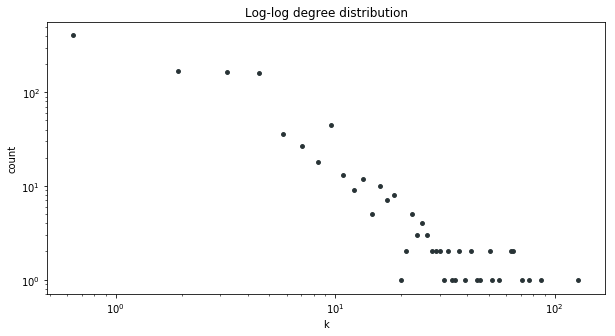

In [15]:
degrees = [d for n, d in SimpsonsFacebook_noSimpsons.degree]
hist, bin_edges = np.histogram(degrees,100)

fig = plt.figure(figsize=(10,5))
center = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.scatter(center,hist,15, c="#283336")
plt.title("Linear degree distribution")
plt.xlabel("k")
plt.ylabel("count")
plt.show()

fig = plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('k')
plt.title("Log-log degree distribution")
plt.xlabel("k")
plt.ylabel("count")
for i, value in enumerate(center):
    ax.scatter(value,hist[i],15, c = '#283336')

In [16]:
# Centralities
b = nx.betweenness_centrality(SimpsonsFacebook_noSimpsons)
betweennessList = sorted(b.items(), key=lambda kv: kv[1], reverse=True)
e = nx.eigenvector_centrality(SimpsonsFacebook_noSimpsons)
eigenList = sorted(e.items(), key=lambda kv: kv[1], reverse=True)

100%|██████████| 500/500 [00:04<00:00, 114.59it/s]


BarnesHut Approximation  took  1.42  seconds
Repulsion forces  took  2.66  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


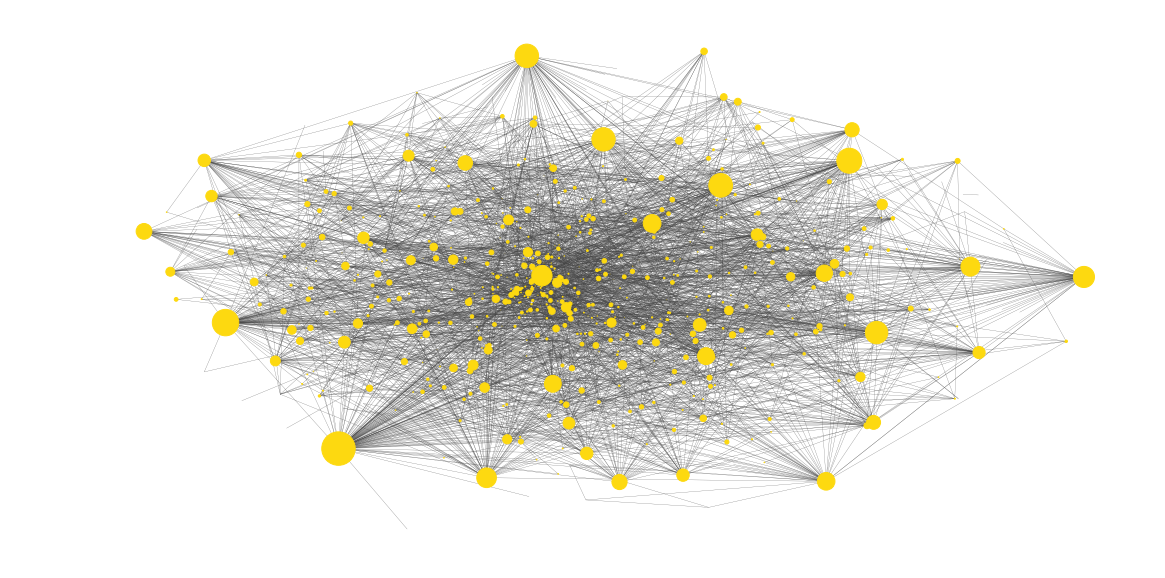

In [17]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.0001,
                          strongGravityMode=False,
                          gravity=2,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(SimpsonsFacebook_noSimpsons, pos=None, iterations=500)

fig = plt.figure(figsize=(20,10))
nx.draw_networkx(
    SimpsonsFacebook_noSimpsons, 
    positions, 
    cmap=plt.get_cmap('jet'), 
    node_size=[b*10000 for b in list(b.values())],
    width=0.2,
    linewidths=1,
    node_color= colors,
    edge_color = '#424242',
    with_labels=False,
    arrows=False
#     with_labels=True,
#     font_size = 5
)
plt.axis('off')
plt.show()

In [18]:
betweennessList[:10]

[('Charles Montgomery Burns', 0.11192172829827543),
 ('Krusty the Clown', 0.06982887463990488),
 ('Milhouse Van Houten', 0.06239626062839648),
 ('Nelson Muntz', 0.05598887906605674),
 ('Ned Flanders', 0.055050560754013565),
 ('Seymour Skinner', 0.0541850151440683),
 ('Edna Krabappel', 0.050073715829503644),
 ('Moe Szyslak', 0.04450633549964461),
 ('Audrey McConnell', 0.04128740364284259),
 ('Abraham Simpson II', 0.03860676831968521)]

100%|██████████| 500/500 [00:04<00:00, 112.54it/s]


BarnesHut Approximation  took  1.45  seconds
Repulsion forces  took  2.63  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


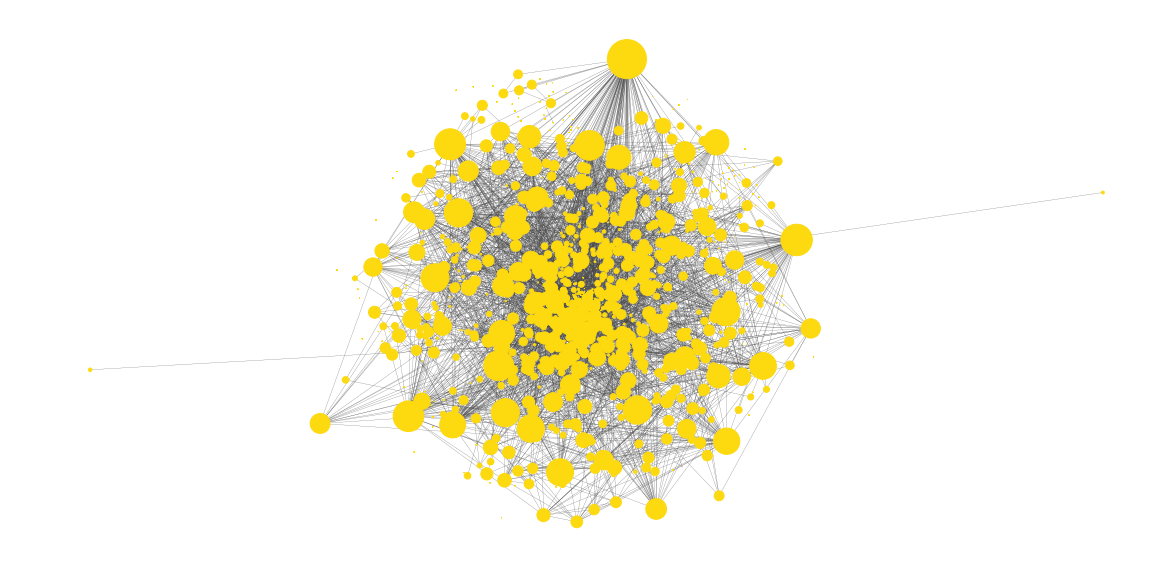

In [19]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.0001,
                          strongGravityMode=False,
                          gravity=2,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(SimpsonsFacebook_noSimpsons, pos=None, iterations=500)

fig = plt.figure(figsize=(20,10))
nx.draw_networkx(
    SimpsonsFacebook_noSimpsons, 
    positions, 
    cmap=plt.get_cmap('jet'), 
    node_size=[e*5000 for e in list(e.values())],
    width=0.2,
    linewidths=1,
    node_color= colors,
    edge_color = '#424242',
    with_labels=False,
    arrows=False
#     with_labels=True,
#     font_size = 5
)
plt.axis('off')
plt.show()

In [20]:
eigenList[:10]

[('Charles Montgomery Burns', 0.306079903383079),
 ('Ned Flanders', 0.19769836259617368),
 ('Seymour Skinner', 0.19172025832772077),
 ('Moe Szyslak', 0.18757410606691893),
 ('Abraham Simpson II', 0.18031436748812252),
 ('Krusty the Clown', 0.17669492151295915),
 ('Milhouse Van Houten', 0.16120944170002058),
 ('Robert Terwilliger', 0.15993789705327552),
 ('Clancy Wiggum', 0.15972692489675913),
 ('Barney Gumble', 0.1578432055501647)]

# Appearance Network

To complement the Facebook network, we created a second network that connects nodes based on if the corresponding characters appeared in the same episode. We created the network a bipartite graph with one set of nodes as the characters and the other as the episodes they appeared in. 

From there, we are able to create undirected networks of each seson by projecting each node's episode connections to the other characters that appeared in that episode. Using this "appearance network", we are able to see each character's popularity arcs throughout the show. Additionally, we are able to see how closely linked a pair of characters is by calculting the percentage of episodes the characters appear together compared to their total appearances. 

In [21]:
Bi_Appearance = nx.read_gpickle('appearance network')
nx.is_connected(Bi_Appearance)
# Dividing the bipartite network to make it possible to connect Homer to every episode
character_nodes, episode_nodes = bipartite.sets(Bi_Appearance)

In [22]:
# Adding Homer to the network because he has no appearances section on his page
Bi_Appearance.add_node('Homer Simpson', bipartite=0)
for e in episode_nodes:
    Bi_Appearance.add_edge('Homer Simpson',e)

In [23]:
# Dividing the bipartite network
character_nodes, episode_nodes = bipartite.sets(Bi_Appearance)

In [24]:
character_nodes

{'Laura Powers',
 'The Thing',
 'Artie Ziff',
 'Scarlet Tanager',
 'Whitney Spuckler',
 'Dr. Zitsofsky',
 'Scott Christian',
 'Rachel Jordan',
 'Opal',
 'Frankie (Health Inspector)',
 'Gil Gunderson',
 'Munchie',
 'Hurt Leg Simpson Relative',
 'Judge Julie',
 'The Raccoon Family',
 'Boy with bangs',
 'Lumpy',
 "Joshua and Amber's Mom",
 'Freddy Quimby',
 'Patty Bouvier',
 'Mr. Gammel',
 'Sandeep Nahasapeemapetilon',
 'Anthony Hopkins',
 'Myra',
 'Kumiko Albertson',
 'Milo',
 'Jimmy the Scumbag',
 '"Suing" Simpson Relative',
 'Harry Houdini',
 'Drummer',
 'Blinky',
 'Pin Pals',
 'Jimbo Jr.',
 'Dia-Betty',
 'Marty (KBBL DJ)',
 'Toucan Sam',
 'Courtney Love',
 'Classy Pig',
 'Shelbyville Manhattan',
 '"Where the Redfern Grows" 5th grader',
 'Avery Mann',
 "Becky's Mother",
 'Charcoal Briquette',
 'Susan',
 'Sandwich Delivery Guy',
 'Chocolate rabbits',
 'Maxwell Flinch',
 "Lewis' lookalike",
 'Hypnotist',
 'Nina Skalka',
 'Rubella Scabies Spuckler',
 'Abbie',
 'Les',
 'Jer',
 'Jude Law',


In [25]:
# Creating the Appearance network by projecting the character part of the network as a weighted graph
AppearanceNetwork = bipartite.weighted_projected_graph(Bi_Appearance,character_nodes)

In [28]:
AppearanceNetwork.degree

DegreeView({'Laura Powers': 90, 'The Thing': 53, 'Artie Ziff': 168, 'Scarlet Tanager': 68, 'Whitney Spuckler': 329, 'Dr. Zitsofsky': 84, 'Scott Christian': 204, 'Rachel Jordan': 59, 'Opal': 78, 'Frankie (Health Inspector)': 74, 'Gil Gunderson': 435, 'Munchie': 97, 'Hurt Leg Simpson Relative': 35, 'Judge Julie': 78, 'The Raccoon Family': 29, 'Boy with bangs': 291, 'Lumpy': 34, "Joshua and Amber's Mom": 83, 'Freddy Quimby': 106, 'Patty Bouvier': 449, 'Mr. Gammel': 44, 'Sandeep Nahasapeemapetilon': 227, 'Anthony Hopkins': 57, 'Myra': 112, 'Kumiko Albertson': 262, 'Milo': 142, 'Jimmy the Scumbag': 114, '"Suing" Simpson Relative': 35, 'Harry Houdini': 77, 'Drummer': 167, 'Blinky': 218, 'Pin Pals': 140, 'Jimbo Jr.': 101, 'Dia-Betty': 172, 'Marty (KBBL DJ)': 204, 'Toucan Sam': 27, 'Courtney Love': 47, 'Classy Pig': 21, 'Shelbyville Manhattan': 29, '"Where the Redfern Grows" 5th grader': 131, 'Avery Mann': 17, "Becky's Mother": 120, 'Charcoal Briquette': 82, 'Susan': 64, 'Sandwich Delivery Guy

In [29]:
print('Connection between Bart and Lisa:', AppearanceNetwork['Bart Simpson']['Lisa Simpson']['weight'] / len(episode_nodes))

Connection between Bart and Lisa: 0.9229583975346687


As expected, Bart and Lisa Simpson are highly connected. Characters that appear in such a high number of shows are bound to have a high connection because there is such little room for them to appear in episodes without the other character. 

In [58]:
apuDegree = Bi_Appearance.degree('Apu Nahasapeemapetilon')
comicDegree = Bi_Appearance.degree('Comic Book Guy')
together = AppearanceNetwork['Apu Nahasapeemapetilon']['Comic Book Guy']['weight']

print('Apu, Comic Book Guy:', together/(apuDegree+comicDegree-together))

Apu, Comic BOok Guy: 0.16748768472906403


Comparing Apu and Comic Book Guy, we see they aren't very highly correlated. Of all the episodes in which they appear, less than 17% of them include both characters. 

In [31]:
nedDegree = Bi_Appearance.degree('Ned Flanders')
krustyDegree = Bi_Appearance.degree('Krusty the Clown')
together = AppearanceNetwork['Ned Flanders']['Krusty the Clown']['weight']

print('Ned, Krusty connection:', together/(nedDegree+krustyDegree-together))

Ned, Krusty connection: 0.2246153846153846


100%|██████████| 500/500 [00:04<00:00, 107.32it/s]


BarnesHut Approximation  took  1.21  seconds
Repulsion forces  took  2.78  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.40  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


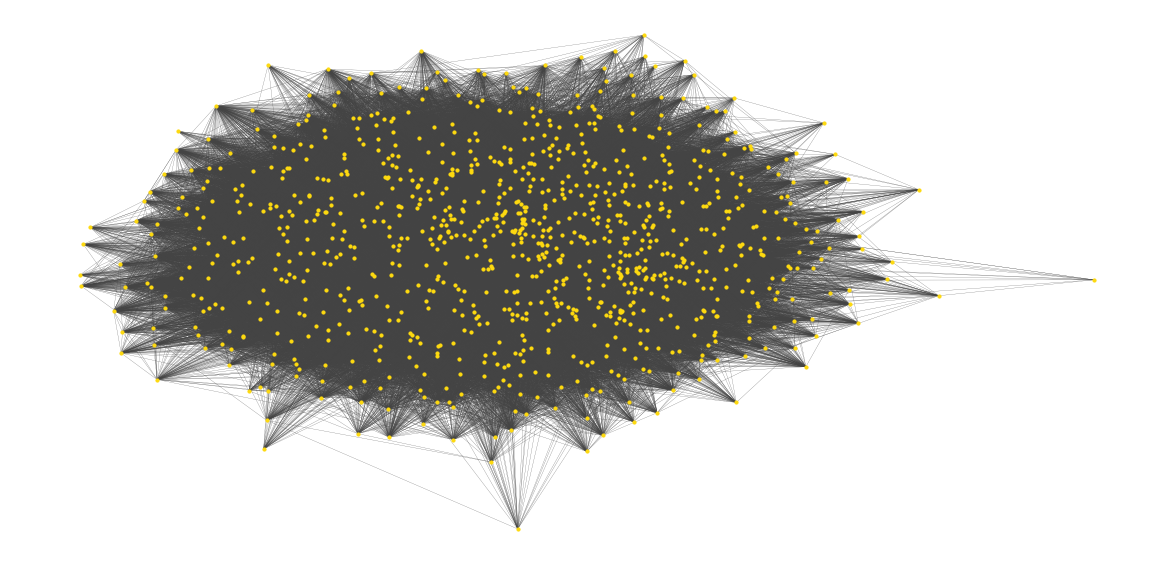

In [32]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.0001,
                          strongGravityMode=False,
                          gravity=2,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(AppearanceNetwork, pos=None, iterations=500)

fig = plt.figure(figsize=(20,10))
nx.draw_networkx(
    AppearanceNetwork, 
    positions, 
    cmap=plt.get_cmap('jet'), 
    node_size=10,
    width=0.2,
    linewidths=1,
    node_color= '#fdd910',
    edge_color = '#424242',
    with_labels=False
)
plt.axis('off')
plt.show()

Above, we see the appearance network in its highly-connected glory. By narrowing the network to the appearances from specific seasons,  these significantly less dense networks give visual information about character connections and also are able to show characters that are important in the season. 

Below, the appearance network is reduced to only include episodes from season 1. While we see there are several 

# why are there nodes without connections in season 1


In [37]:
seasons = get_season_dictionary()

In [38]:
Season1 = Bi_Appearance.copy()
Season1.remove_nodes_from([e for e in episode_nodes if e not in seasons[1]])

Season1 = bipartite.weighted_projected_graph(Season1,character_nodes)

100%|██████████| 500/500 [00:04<00:00, 117.55it/s]


BarnesHut Approximation  took  0.93  seconds
Repulsion forces  took  3.05  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


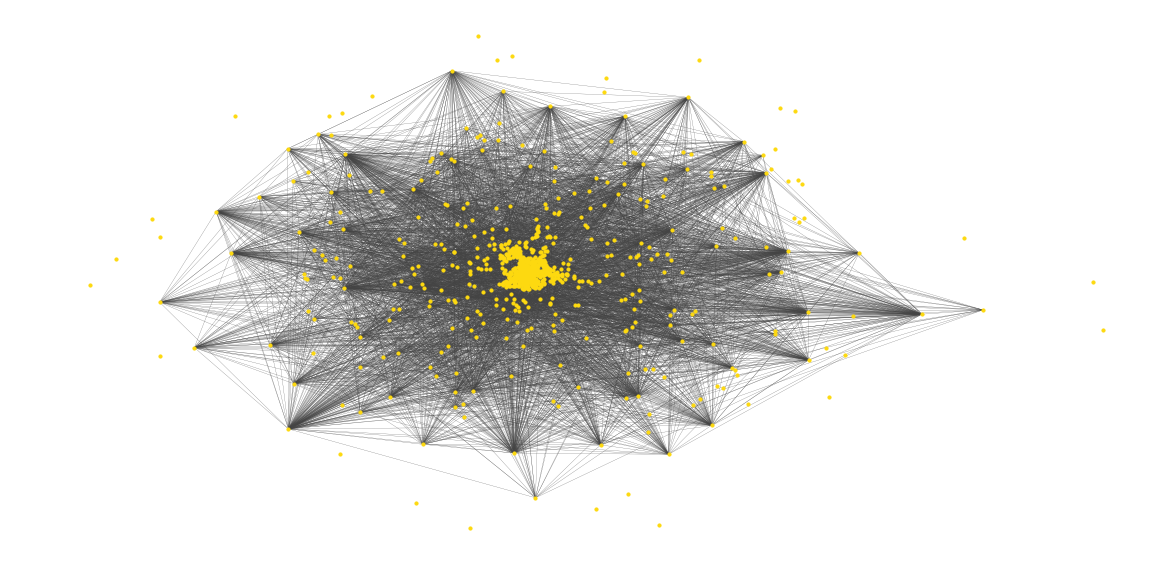

In [39]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.0001,
                          strongGravityMode=False,
                          gravity=2,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(Season1, pos=None, iterations=500)

fig = plt.figure(figsize=(20,10))
nx.draw_networkx(
    Season1, 
    positions, 
    cmap=plt.get_cmap('jet'), 
    node_size=10,
    width=0.2,
    linewidths=1,
    node_color= '#fdd910',
    edge_color = '#424242',
    with_labels=False
)
plt.axis('off')
plt.show()

Though we are largely unable to draw important insight from the graph, we are still able to manipulate the data to see characters' introductions to the show, their rise in popularity, and how well they stayed in prevalence. For example, Comic Book Guy appears to have bursts of popularity before largely disappearing, while 

# insert character that consistently appears but isn't a main character

has a more consistent role in the show. Feel free to explore using any of the names in the network. 

Input a name: Comic Book Guy
Season  1 :  0
Season  2 :  1
Season  3 :  7
Season  4 :  16
Season  5 :  1
Season  6 :  0
Season  7 :  6
Season  8 :  4
Season  9 :  1
Season  10 :  4
Season  11 :  2
Season  12 :  4
Season  13 :  2
Season  14 :  1
Season  15 :  4
Season  16 :  1
Season  17 :  0
Season  18 :  0
Season  19 :  0
Season  20 :  1
Season  21 :  2
Season  22 :  2
Season  23 :  3
Season  24 :  3
Season  25 :  5
Season  26 :  3
Season  27 :  6
Season  28 :  6
Season  29 :  9
Season  30 :  0


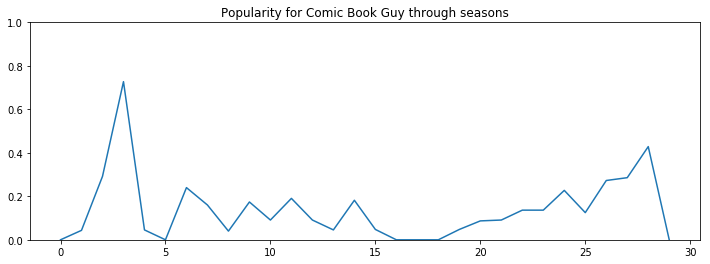

In [41]:

name = input('Input a name: ')
appearances_through_seasons = []
for i in seasons.keys():
    # Create a tmp copy for the actual season based on the complete network
    Season = Bi_Appearance.copy()
    # Remove all the nodes which are not in the actual season
    Season.remove_nodes_from([e for e in episode_nodes if e not in seasons[i]])
    # Check the degree as a 'popularity' factor
    print('Season ',i,': ',Season.degree(name))
    
    # Building the list for the plot's y axis. 
    # There's more meaning to show the percentage than the number itself, 
    # because the episode number can vary between seasons
    
    appearances_through_seasons.append(Season.degree(name)/len(seasons[i]))
    
fig = plt.figure(figsize=(12,4))
plt.plot(np.arange(30), appearances_through_seasons)
plt.ylim(0,1)
plt.title(f'Popularity of {name} through seasons')
plt.show()

# Word Clouds

As a more entertaining way to show off the Simpsons universe, we retrieved the total 

In [42]:
# Opening the previously exported TF-IDF scores for each character
with open("characterQuoteStringsTfIdf.json") as f:
    tfidfDict = json.load(f)
f.close()

In [43]:
#Homer
homer_coloring = np.array(Image.open('pictures/Homer_Simpson.jpg'))
wc_homer = WordCloud(background_color="white",
                     max_words=4000,
                     mask=homer_coloring,
                     max_font_size=100,
                     random_state=42,
                     collocations=False)

#Marge
marge_coloring = np.array(Image.open('pictures/Marge_Simpson.jpeg'))
wc_marge = WordCloud(background_color="white",
                     max_words=4000,
                     mask=marge_coloring,
                     max_font_size=100,
                     collocations = False,
                     random_state=42)

#Bart
bart_coloring = np.array(Image.open('pictures/Bart_Simpson.jpg'))
wc_bart = WordCloud(background_color="white",
                    max_words=4000,
                    mask=bart_coloring,
                    max_font_size=100,
                    collocations=False,
                    random_state=42)

#Lisa
lisa_coloring = np.array(Image.open('pictures/LisaTransparent.png'))
wc_lisa = WordCloud(background_color="white",
                    max_words=4000,
                    mask=lisa_coloring,
                    max_font_size=100,
                    collocations=False,
                    random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: 'pictures/Homer_Simpson.jpg'

In [ ]:
wc_homer.generate(tfidfDict['homer'])
wc_marge.generate(tfidfDict['marge'])
wc_bart.generate(tfidfDict['bart'])
wc_lisa.generate(tfidfDict['lisa'])

In [ ]:
image_colors_homer = ImageColorGenerator(homer_coloring)
image_colors_marge = ImageColorGenerator(marge_coloring)
image_colors_bart = ImageColorGenerator(bart_coloring)
image_colors_lisa = ImageColorGenerator(lisa_coloring)

In [ ]:
# Lisa
# fig = plt.figure(figsize=(20,20))
plt.imshow(wc_lisa.recolor(color_func=image_colors_lisa),interpolation="bilinear",)
plt.axis("off")
plt.savefig("final_wordclouds/Lisa_WordCloud.png",dpi=1000)

In [ ]:
# Bart
# fig = plt.figure(figsize=(300,300))
plt.imshow(wc_bart.recolor(color_func=image_colors_bart),interpolation="bilinear")
plt.axis("off")
plt.savefig("final_wordclouds/Bart_WordCloud.png",dpi=1000)

In [ ]:
# Marge
# fig = plt.figure(figsize=(300,300))
plt.imshow(wc_marge.recolor(color_func=image_colors_marge),interpolation="bilinear")
plt.axis("off")
plt.savefig("final_wordclouds/Marge_WordCloud.png",dpi=1000)

In [ ]:
# Homer
# fig = plt.figure(figsize=(300,300))
plt.imshow(wc_homer.recolor(color_func=image_colors_homer),interpolation="bilinear")
plt.axis("off")
plt.savefig("final_wordclouds/Homer_WordCloud.png",dpi=1000)

# Sentiment Analysis

In [ ]:
sentimentDict={}
filePath = 'https://journals.plos.org/plosone/article/file?type=supplementary&id=info%3Adoi%2F10.1371%2Fjournal.pone.0026752.s001'
response = request.urlopen(filePath)
data = response.read()
text = data.decode('utf-8')
for line in text.split('\n')[4:]:
    listThing=line.split('\t')
    if len(listThing) > 3:
        sentimentDict[listThing[0]]=[listThing[2],listThing[3]]

#Global services 800-992-4685

#opersations 877-742-9488

#@jit(cache=True)
def sentiment(list_of_tokens):
    sentiment_num=0
    sentiment_denom=0
    for token in list_of_tokens:
        if sentimentDict.get(token):
            sentiment_num+=float(sentimentDict[token][0])
            sentiment_denom+=1
    return (sentiment_num,sentiment_denom)

with open('characterQuotesBySeason.json') as f:
    data = json.load(f)
f.close()

personScoresPerSeason={}
happyScores={}
numberOfWords={}
characterIndividWordScores={}


for season in data: 
    for person in data[season].keys():
        strippedName=person.strip()
        if not characterIndividWordScores.get(strippedName):
            characterIndividWordScores[strippedName]={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0,'10':0}
        
        for word in word_tokenize(data[season][person]):
            try:
                characterIndividWordScores[strippedName][str(int(round(sentiment([word])[0])))]+=1
            except:
                pass
        #actualWords[strippedName]=[(x,sentiment([x])[0]) for x in word_tokenize(data[season][person])]
        val=sentiment(word_tokenize(data[season][person]))
        if not numberOfWords.get(strippedName):
            numberOfWords[strippedName]=0
        numberOfWords[strippedName]+=len(word_tokenize(data[season][person]))
        if not personScoresPerSeason.get(strippedName):
            personScoresPerSeason[strippedName]=[]
        personScoresPerSeason[strippedName].append(val)
      
for person in personScoresPerSeason:
    numerator=0
    denominator=0
    for item in personScoresPerSeason[person]:
        numerator+=item[0]
        denominator+=item[1]
    if denominator!=0:
        happyScores[person]=numerator/denominator
    else:
        happyScores[person]=''


k_keys_sorted = heapq.nlargest(20, numberOfWords, key=numberOfWords.get)

finalArr=[(x,happyScores[x],characterIndividWordScores[x]) for x in k_keys_sorted]
finalDict={}

for i in range(len(k_keys_sorted)):
    finalDict[k_keys_sorted[i]]=[happyScores[k_keys_sorted[i]],characterIndividWordScores[k_keys_sorted[i]] ]


In [ ]:
nameHere=input("input a name. for a list of names, type 'help'.")
if nameHere=='help':
    for name in finalDict.keys():
        print(name) 
else:
    pos = np.arange(len(finalDict[nameHere][1]))
    width = 1.0 # gives histogram aspect to the bar diagram
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(finalDict[nameHere][1].keys())
    print(finalDict[nameHere][1].values())
    plt.bar(finalDict[nameHere][1].keys(), finalDict[nameHere][1].values(), width, color='g')
    plt.show()

In [ ]:
nameHere=input("input a name. for a list of names, type 'help'.")
if nameHere=='help':
    for name in finalDict.keys():
        print(name) 
else:
    pos = np.arange(len(finalDict[nameHere][1]))
    width = 1.0 # gives histogram aspect to the bar diagram
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(finalDict[nameHere][1].keys())

    plt.bar(finalDict[nameHere][1].keys(), finalDict[nameHere][1].values(), width, color='g')
    plt.show()